In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from picar import back_wheels, front_wheels
import picar
from movement import Movement
from cameraUtils import Camera
import time
import cv2
from pyzbar.pyzbar import decode
from PIL import Image
import qrcode

In [2]:
picar.setup()
db_file = "/home/pi/SunFounder_PiCar-V/remote_control/remote_control/driver/config"

In [3]:
mov = Movement()
cam = Camera()

DEBUG "front_wheels.py": Set debug off
DEBUG "front_wheels.py": Set wheel debug off
DEBUG "Servo.py": Set debug off
DEBUG "back_wheels.py": Set debug off
DEBUG "TB6612.py": Set debug off
DEBUG "TB6612.py": Set debug off
DEBUG "PCA9685.py": Set debug off
DEBUG "camera.py": Set debug off
DEBUG "camera.py": Set pan servo and tilt servo debug off
DEBUG "Servo.py": Set debug off
DEBUG "Servo.py": Set debug off


In [13]:
def scanForLandmark(target='Landmark 2', verbose = False, display = False):
    def scanClockwise():
        mov.turnRight(35)
        mov.moveForwardDist(0.2)
        mov.turnLeft(35)
        mov.moveBackwardDist(0.2)
        mov.turnStraight()

    def scanAntiClockwise():
        mov.turnLeft(35)
        mov.moveForwardDist(0.1)
        mov.turnRight(35)
        mov.moveBackwardDist(0.1)
        mov.turnStraight()
    
    for i in range(20):
        qrInfo = getQRInfo(display = display, verbose = verbose, target = target)
        if qrInfo['success']:
            return True
            break
        else:
            scanAntiClockwise()
    return False
            
def getQRInfo(target = 'all', display = False, verbose = False):

    _, img = cv2.VideoCapture(-1).read()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fcy, fcx = img.shape[:2]
    fcy = int(fcy/2)
    fcx = int(fcx/2)
    details = decode(img)
    info = {}
    qrInfo = []
    info['success'] = False
#     bp()
    for detail in details:
        if target != 'all' and detail.data != target:
            continue
        info['success'] = True
        info['data'] = detail.data
        xc, yc = detail.rect.left + int(detail.rect.width/2), detail.rect.top + int(detail.rect.height/2)
        info['xc'] = xc
        info['yc'] = yc
        info['width'] = detail.rect.width
        info['height'] = detail.rect.height

        # Quadratic relation
        params = [0.00253, -1.42, 223.6 ]
        info['dist'] = round(params[0]*(info['width']**2) + params[1]*(info['width']) + params[2])

        # Linear relation
#         params = [-0.369 , 109.5 ]
#         info['dist'] = round(params[0]*info['width'] + params[1])

        info['fcx'] = fcx
        info['fcy'] = fcy
        xdist = (17.0/info['width'])*abs(fcx-xc)
        angle_steer = np.arctan(xdist/float(info['dist']))
        info['steer_angle'] = np.rad2deg(angle_steer).astype(int)
        info['right_steer'] = True if xc > fcx else False
        
        if verbose:
            print info
        if target == 'all':
            qrInfo.append(info.copy())
    if display:
        plt.imshow(img, cmap='gray', interpolation='bicubic')
        plt.show()
    if target == 'all':
        return qrInfo
    else:
        return info
    

def moveTowardsTarget(target = 'all', display = False, verbose = False):
    mov.turnStraight()
    near_end = False
    while True:
        details = getQRInfo(target = target, display = display, verbose = verbose)
        if details['success']:
            if verbose:
                print ("Frame detected")
            if details['dist'] <= 50:
                mov.stop()
                break
                print("Reached destination")
            else:
                if details['dist'] <= 80:
                    near_end = True
                if details['right_steer']:
                    mov.turnRight(details['steer_angle'])
                    print ("Turn right angle: ", details['steer_angle'])
                else:
                    mov.turnLeft(details['steer_angle'])
                    print ("Turn left angle: ", details['steer_angle'])
            if near_end:
                mov.moveForwardDist( (details['dist']-50) *0.01 )
            else:
                mov.moveForwardDist(0.25)
            mov.turnStraight()
        else:
            mov.moveForwardDist(0.15)

            #             scanForLandmark(target)

#         mov.turnStraight()
        if near_end:
            break


[[  2.52729354e-03]
 [ -1.41712215e+00]
 [  2.23600628e+02]]


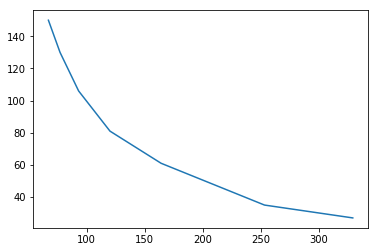

In [3]:
def paramCalibration(pixel_width, dist_in_cm):
    nData = pixel_width.shape[0]
    D = np.ones((nData,3 ))
    for i in range(nData):
        D[i,0] = pixel_width[i]**2
        D[i,1] = pixel_width[i]
        D[i,2] = 1
        #     print D
    Dinv = np.linalg.pinv(D)
    params = np.matmul(Dinv, dist_in_cm)
    print(params)
pixel_width = np.array([67, 77 , 93, 120, 164, 253, 329])
dist_in_cm = np.array([150, 130 , 106, 81, 61, 35, 27]).reshape((-1,1))
paramCalibration(pixel_width, dist_in_cm)
plt.plot(pixel_width, dist_in_cm)
plt.show()

{'dist': 131.0, 'success': True, 'fcx': 320, 'xc': 289, 'yc': 271, 'height': 74, 'width': 75, 'fcy': 240, 'steer_angle': 3, 'right_steer': False, 'data': 'Landmark 1'}


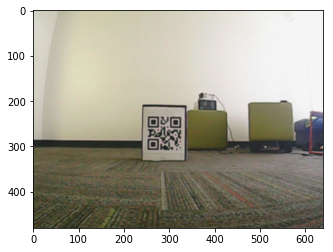

In [6]:
details = getQRInfo(target = 'all', display = True, verbose = True)

In [7]:
# mov.stop()

In [8]:
# moveTowardsTarget('Landmark 3', verbose = True, display = True)

In [17]:
verbose = True
display = False
moveTowardsTarget('Landmark 1', verbose = verbose, display = display)
scanForLandmark('Landmark 2', verbose = verbose, display = display)
moveTowardsTarget('Landmark 2', verbose = verbose, display = display)
scanForLandmark('Landmark 3', verbose = verbose, display = display)
moveTowardsTarget('Landmark 3', verbose = verbose, display = display)
mov.turnLeftNinty()
mov.turnLeftFortyFive()

{'dist': 134.0, 'success': True, 'fcx': 320, 'xc': 291, 'yc': 274, 'height': 72, 'width': 72, 'fcy': 240, 'steer_angle': 2, 'right_steer': False, 'data': 'Landmark 1'}
Frame detected
('Turn left angle: ', 2)
{'dist': 120.0, 'success': True, 'fcx': 320, 'xc': 353, 'yc': 268, 'height': 86, 'width': 86, 'fcy': 240, 'steer_angle': 3, 'right_steer': True, 'data': 'Landmark 1'}
Frame detected
('Turn right angle: ', 3)
{'dist': 100.0, 'success': True, 'fcx': 320, 'xc': 369, 'yc': 260, 'height': 109, 'width': 108, 'fcy': 240, 'steer_angle': 4, 'right_steer': True, 'data': 'Landmark 1'}
Frame detected
('Turn right angle: ', 4)
{'dist': 71.0, 'success': True, 'fcx': 320, 'xc': 374, 'yc': 248, 'height': 146, 'width': 145, 'fcy': 240, 'steer_angle': 5, 'right_steer': True, 'data': 'Landmark 1'}
Frame detected
('Turn right angle: ', 5)
{'dist': 145.0, 'success': True, 'fcx': 320, 'xc': 110, 'yc': 290, 'height': 65, 'width': 62, 'fcy': 240, 'steer_angle': 21, 'right_steer': False, 'data': 'Landmark 

In [12]:
mov.stop()